# DC-EGM med Max's Model

## load packages and dependencies

In [2]:
#Dependencies
import jax.numpy as jnp
import numpy as np
from dcegm.pre_processing.setup_model import setup_model
import jax

from typing import Tuple

import pandas as pd
import matplotlib.pyplot as plt

from dcegm.sim_interface import get_sol_and_sim_func_for_model
from dcegm.simulation.sim_utils import create_simulation_df

from scipy.optimize import minimize

import statsmodels.api as sm

import os

import sys
sys.path.insert(0,"/Users/frederiklarsen/dcegm/Speciale")
sys.path.insert(1,"/Users/frederiklarsen/dcegm/")

from model_functions.utility import utility_functions
from model_functions.final_period_utility import final_period_utility
from model_functions.budget import budget_dcegm
from model_functions.state_space_functions import create_state_space_function_dict
from model_functions.compute_moments import compute_simulation_moments
from model_functions.compute_moments import compute_simulation_moments_with_ci
from model_functions.plots import plot_empirical_vs_simulated_with_ci
from model_functions.estimation import estimate_msm

from first_step.mortality import prob_survival

from dcegm.interface import validate_exogenous_processes

# ── Configurating file-location -────────────────────────────────────────────────
DATA_DIR    = "/Users/frederiklarsen/Data"
FILE_UDD1   = os.path.join(DATA_DIR, "momenter/moments_udd1.txt")
FILE_UDD2   = os.path.join(DATA_DIR, "momenter/moments_udd2.txt")
FILE_UDD3   = os.path.join(DATA_DIR, "momenter/moments_udd3.txt")
Mortality   = os.path.join(DATA_DIR, "mortality.xlsx")
# ────────────────────────────────────────────────────────────────────────────────

##### Git Commit Hash ee6660e #####
##### Git Branch = origin(aux-budget) #####
# ────────────────────────────────────────────────────────────────────────────────


jax.config.update("jax_enable_x64", True)

MLE estimates: alpha1 = 0.000417, alpha2 = 0.099277


## Load Data 

In [3]:
# Read CSV
df_edu_1 = pd.read_csv(FILE_UDD1)
df_edu_2 = pd.read_csv(FILE_UDD2)
df_edu_3 = pd.read_csv(FILE_UDD3)
# read mortality and discard seoncd and third column
df_mort = pd.read_excel(Mortality, sheet_name="DOD", usecols=[0, 3])

# 2) standardize colomn name and remove _FREQ_ column
for df in (df_edu_1, df_edu_2, df_edu_3):
    # Rename ALDER → age
    if "ALDER" in df.columns:
        df.rename(columns={"ALDER": "age"}, inplace=True)
    # Remove _FREQ_-column if it exists
    if "_FREQ_" in df.columns:
        df.drop(columns=["_FREQ_"], inplace=True)


 # 3) Divide wage by 10 to get it in 100000 dkk
for df in (df_edu_1, df_edu_2, df_edu_3):
    if "avg_wage" in df.columns:
        df["avg_wage"] = df["avg_wage"]

# 4) (Valgfrit) Kontrolprint 
#df_edu_1

## Options for model - Choices and states

In [4]:
n_periods = 55
choices = np.arange(5) # 5 choices

options = {
    "model_params": {
        #"quadrature_points_stochastic": 5, 
        "n_quad_points_stochastic": 25,
        "n_periods": n_periods,
        "choices": choices, # 4 choices
        "hours": jnp.array([0,250,750,1200,1700]), #list 
        "max_hours": 1500,
        "start_age": 30,
        "inc_threshold": 6.0,
        "tax_base_rate": 0.37,
        "tax_top_rate": 0.5,
        "retirement_age": 67,
        "oap_base_amount":0.80328,
        "oap_max_supplement": 0.92940,
        "supp_threshold": 0.79300,
        "oap_threshold": 3.3592,
        "supp_reduction_rate": 0.309,
        "oap_reduction_rate": 0.3,
        "alpha1": 0.000417, # independently estimated parameter for survival probability
        "alpha2": 0.1,  # independently estimated parameter for survival probability
        "max_init_experience": 5,
        "max_ret_period": 45, # Age 75
        "min_ret_period": 30, # Age 60
    },
    "state_space": {
        "n_periods": n_periods,
        "choices": choices, # 4 choices
        "continuous_states": {
            "wealth": np.linspace(0, 50, 20),
            "experience": jnp.linspace(0, 1, 5).astype(float) # 1 experince grid point, if experience can only go up by a year - more points if it is a fraction based on hours worked
        },
        "exogenous_processes": {
            "survival": {
                "transition": prob_survival,
                "states": [0, 1],
            },
        },
    },
}

# ====================================================================================================================

# Structural Estimation

## Initiatal parameters - some are estimated above, the rest to be structuraly estimated

In [5]:
beta0, beta1, beta2 = np.loadtxt("/Users/frederiklarsen/dcegm/Speciale/first_step/wage_params_udd2.txt")

params_initial = {}
params_initial["interest_rate"] = 0.01
params_initial["sigma"] = 0.11436398 # income shock scale
params_initial["lambda"] = 0.96854512 # taste shock scale

# discount factor
params_initial["beta"] = 0.99633022

# parameters for the utility function
params_initial["rho"]=0.77007267

# disutility of each hours choice
params_initial["gamma"]=jnp.array([0.7949593,1.65520093,2.12902941,1.73385035]) 

# Age component disutility
# params_initial["kappa1"]=0.06931974
params_initial["kappa2"]=0.00377771

# transsition cost
params_initial["phi"]=0.99926288

# bequest parameters
params_initial["b_scale"]=1.53314057
params_initial["xi"]=0.18549496


# labor market parameters
params_initial["eta_edu1"]=1.81532136


# mortality parameters
params_initial["alpha1"]=0.000417
params_initial["alpha2"]=0.099277



# wage parameters
# ----- EDU LEVEL 2 -----
params_initial["beta0"]=beta0
params_initial["beta1"]=beta1
params_initial["beta2"]=beta2


params=params_initial.copy()

### Setup the model

In [6]:
model = setup_model(
    options=options,
    state_space_functions=create_state_space_function_dict(),
    utility_functions=utility_functions,
    utility_functions_final_period=final_period_utility,
    budget_constraint=budget_dcegm,
)

State specific choice set not provided. Assume all choices are available in every state.
Update function for state space not given. Assume states only change with an increase of the period and lagged choice.
Sparsity condition not provided. Assume all states are valid.
Starting state space creation
State space created.

Starting state-choice space creation and child state mapping.
State, state-choice and child state mapping created.

Start creating batches for the model.
The batch size of the backwards induction is  50
Model setup complete.



In [ ]:
# # validate model
# validate_exogenous_processes(model, params)

# ====================================================================================================================

## Initial values for simulating. 

In [7]:
# Select number of individuals for simulation
n_individuals = 10000

seed = 132



key = jax.random.PRNGKey(0)              # whatever seed you like
n = n_individuals                        # how many draws

# define your class‐labels and their probabilities
labels = jnp.array([0, 1, 2, 3], dtype=jnp.int32)
probs  = jnp.array([0.25, 0.20, 0.25, 0.509])  # sums to 1.0

lagged_choice = jax.random.choice(
    key,
    a       = labels,
    shape   = (n,),
    p       = probs,
    replace = True
)
# set initial states for each individual
states_initial = {
    "period": jnp.zeros(n_individuals),       # Every individual starts at period 0 (age 30)
    "lagged_choice": lagged_choice,  # Every individual starts with choice 3 (work fulltime)
    "experience": jnp.full(n_individuals, 0.8).astype(float),  # Every individual starts with 5 years of experience
    "survival": jnp.ones(n_individuals), # Every individual starts with 1 (alive)
}

# Set wealth at beginning of period, which is the starting wealth for every individual. 
wealth_initial = jnp.full(n_individuals, 0.59)   # Every individual starts with 59k wealth - to be adjusted based on the actual moments

## Simulate model

In [8]:
sim_func_aux = get_sol_and_sim_func_for_model(
    model=model,
    states_initial=states_initial,
    wealth_initial=wealth_initial,
    n_periods=options["state_space"]["n_periods"],
    seed=seed,
)


In [9]:
output_dict_aux = sim_func_aux(params)

## Convert simulation results to DataFrame

In [10]:
df_sim = create_simulation_df(output_dict_aux["sim_dict"])

#print to excel
#df_sim.to_excel("/Users/frederiklarsen/Library/Mobile Documents/com~apple~CloudDocs/KU/Speciale/Resultater/simulation_output.xlsx")


#print all individuals
#df_sim


#print a select individual
df_sim.loc[(slice(None), 20),:] 

,,acc_exp,choice,consumption,experience,income_shock,labor_income,lagged_choice,lumpsum,net_labor,period_pension,...,taste_shocks_0,taste_shocks_1,taste_shocks_2,taste_shocks_3,taste_shocks_4,value_choice_0,value_choice_1,value_choice_2,value_choice_3,value_choice_4
period,agent,,,,,,,,,,,,,,,,,,,,,
0,20,NaN,4,0.590000,0.800000,0.163204,NaN,3,NaN,NaN,NaN,...,0.242039,-0.530902,-1.804961,-0.035483,1.650649,14.933144,13.137574,11.658791,14.554698,16.720128
1,20,5.855556,4,1.288157,0.855556,0.061936,4.439005,4,0.000000,2.796573,0.000000,...,-1.196616,0.701125,-0.465597,-1.112340,1.301568,15.471897,16.639569,15.291330,14.796195,19.725952
2,20,6.790476,4,1.402507,0.895238,-0.090055,4.121332,4,0.000000,2.596439,0.000000,...,-0.986671,0.858799,-0.377603,1.171587,-0.159322,16.916181,18.166946,16.720634,18.429845,19.646405
3,20,7.775000,4,1.448489,0.925000,-0.098052,3.634239,4,0.000000,2.289571,0.000000,...,-1.514331,0.352353,0.770486,-1.240583,1.006586,17.266987,18.561919,18.789358,16.957355,21.787040
4,20,8.792593,4,1.487935,0.948148,0.075217,3.698093,4,0.000000,2.329798,0.000000,...,-0.288386,0.640938,0.667097,-1.516968,0.014492,19.333614,19.713950,19.568999,17.583156,21.730914
5,20,9.833333,0,1.416455,0.966667,-0.030854,4.507311,4,0.000000,2.839606,0.000000,...,1.708537,-1.417620,-2.020708,-0.180538,-1.624801,22.571036,18.918345,18.165334,20.222784,21.425942
6,20,10.272727,4,1.512248,0.878788,0.246919,0.000000,0,0.000000,0.000000,0.000000,...,-0.690122,-0.531204,0.583812,0.200107,-0.223489,19.849962,18.489664,19.473100,19.321749,20.568362
7,20,11.300000,4,1.552576,0.900000,-0.038156,5.608216,4,0.000000,3.533176,0.000000,...,0.240256,-0.406567,0.819655,0.239593,0.092794,21.553383,20.409802,21.526318,21.196556,23.747195
8,20,12.343590,4,1.573482,0.917949,-0.147346,4.311879,4,0.000000,2.716484,0.000000,...,0.834171,0.392599,0.298224,-1.452294,-0.166818,23.121578,22.198941,22.015352,20.530743,24.535357


In [11]:
def compute_simulation_moments(df_sim, start_age, hours_map):
    """
    Konverter et simuleret DataFrame til et moments DataFrame,
    men kun for agenter med survival == 1.
    """
    # 1) Reset index og beregn 'age'
    df = df_sim.reset_index()
    df["age"] = df["period"] + start_age

    # 2) Filtrer kun de levende
    df_alive = df[df["survival"] == 1].copy()

    # 3) Map 'choice' til 'hours_value'
    df_alive["hours_value"] = df_alive["choice"].map(hours_map)

    # 4) Gruppér på age (kun levende)
    grouped = df_alive.groupby("age")

    # 5) Sandsynlighed for at arbejde (choice != 0)
    prob_work = grouped["choice"].apply(lambda x: (x != 0).mean())

    # 6) Fraktion i hver hours‐cluster
    hours_cluster = {
        f"hours_{cat}": grouped["choice"]
            .apply(lambda x, cat=cat: (x == cat).mean())
        for cat in sorted(hours_map.keys())
    }

    # 7) Gennemsnitlig formue i periodens start
    avg_wealth = grouped["wealth_beginning_of_period"].mean()

    # 8) Transitioner work->work og nowork->nowork
    work_work = grouped.apply(
        lambda g: ((g["lagged_choice"] != 0) & (g["choice"] != 0)).mean(),
        include_groups=False
    )

    nowork_nowork = grouped.apply(
        lambda g: ((g["lagged_choice"] == 0) & (g["choice"] == 0)).mean(),
        include_groups=False
    )

    # 9) Betingede momenter for arbejdende
    avg_wage  = grouped["wage"].mean()
    avg_hours = df_alive[df_alive["choice"] != 0].groupby("age")["hours_value"].mean()
    var_wage  = grouped["wage"].var()
    skew_wage = grouped["wage"].skew()

    net_labor = df_alive.groupby("age")["net_labor"].mean()
    survival  = grouped["survival"].mean()  # =1 for alle her

    # 10) Pens hvis det findes, ellers 0
    if "lumpsum" in df_alive:
        pens = grouped["lumpsum"].mean()
    else:
        pens = pd.Series(0.0, index=grouped.groups.keys())

    # Consumption
    avg_consumption = df_alive.groupby("age")["consumption"].mean()

    #nr of individuals at each age
    n_individuals = df_alive.groupby("age")["agent"].count()

    # avg accumulated experience
    avg_experience = grouped["acc_exp"].mean()

    # 11) Sammensæt resultat‐DataFrame
    moments_df = pd.DataFrame({
        "age":            grouped["age"].first(),
        "prob_work":      prob_work,
        **hours_cluster,
        "avg_wealth":     avg_wealth,
        "work_work":      work_work,
        "nowork_nowork":  nowork_nowork,
        "avg_wage":       avg_wage,
        "avg_hours":      avg_hours,
        "var_wage":       var_wage,
        "skew_wage":      skew_wage,
        "pens":           pens,
        "net_labor":      net_labor,
        "survival":       survival,
        "avg_consumption": avg_consumption,
        "n_individuals": n_individuals,
        "avg_experience": avg_experience,
    })

    # 12) Ryd op: sortér, nulstil index og sæt NaN til 0
    moments_df = moments_df.sort_index().reset_index(drop=True)
    moments_df.fillna(0.0, inplace=True)

    return moments_df
# hours_map = options["model_params"]["hours"]
hours_map = {0: 0, 1: 250, 2: 750, 3: 1300, 4: 1900}
# start_age = options["model_params"]["start_age"]
start_age = 30  # Or start_age = options["model_params"]["start_age"]


moments_sim = compute_simulation_moments(df_sim, start_age, hours_map)
moments_sim


,age,prob_work,hours_0,hours_1,hours_2,hours_3,hours_4,avg_wealth,work_work,nowork_nowork,avg_wage,avg_hours,var_wage,skew_wage,pens,net_labor,survival,avg_consumption,n_individuals,avg_experience
0,30,0.687500,0.312500,0.111400,0.091200,0.137600,0.347300,0.590000,0.594400,0.114500,0.000000,1360.000000,0.000000e+00,0.000000,0.000000,0.000000,1.0,0.555735,10000,0.000000
1,31,0.708300,0.291700,0.082200,0.068700,0.086300,0.471100,1.370489,0.567400,0.171600,0.002229,1523.867006,6.517523e-08,0.335421,0.000000,1.197466,1.0,0.833671,10000,5.761309
2,32,0.754851,0.245149,0.071414,0.060712,0.083617,0.539108,2.058418,0.608822,0.145629,0.002294,1584.941036,6.900535e-08,0.328951,0.000000,1.411244,1.0,0.989746,9998,6.491107
3,33,0.797739,0.202261,0.071621,0.062419,0.077523,0.586176,2.748125,0.666400,0.113834,0.002354,1603.573668,7.162568e-08,0.365651,0.000000,1.602623,1.0,1.113694,9997,7.227088
4,34,0.826913,0.173087,0.069235,0.057729,0.076638,0.623312,3.446934,0.711856,0.087144,0.002414,1625.958863,7.523891e-08,0.337805,0.000000,1.754543,1.0,1.215455,9995,7.981658
5,35,0.848433,0.151567,0.067274,0.056062,0.070377,0.654720,4.170345,0.745921,0.070578,0.002477,1643.410029,8.172682e-08,0.332513,0.000000,1.890808,1.0,1.299634,9989,8.758087
6,36,0.863422,0.136578,0.062081,0.058776,0.070692,0.671873,4.919486,0.769400,0.057575,0.002532,1653.954540,8.415727e-08,0.332525,0.000000,2.004544,1.0,1.368122,9987,9.556527
7,37,0.870580,0.129420,0.057097,0.050887,0.071722,0.690874,5.700206,0.784233,0.050285,0.002594,1675.135197,8.921822e-08,0.359388,0.000000,2.102533,1.0,1.421998,9983,10.373468
8,38,0.884681,0.115319,0.061116,0.052199,0.072337,0.699028,6.516878,0.800120,0.044885,0.002651,1669.099660,9.219143e-08,0.345987,0.000000,2.189752,1.0,1.462983,9981,11.207186
9,39,0.900211,0.099789,0.055561,0.050948,0.072410,0.721292,7.377499,0.820379,0.035403,0.002711,1684.815062,9.394405e-08,0.350363,0.000000,2.268607,1.0,1.498933,9971,12.054083


# Estimation

In [ ]:
#keep_cols = ["hours_0","hours_1","hours_2","hours_3", "hours_4","avg_wealth", "avg_hours"]
keep_cols = ["hours_1","hours_2","hours_3", "hours_4", "avg_hours", "avg_wealth"]
def crit_func_scipy(theta_array):
    """
    High-level objective function for MSM that updates all parameters,
    runs the simulation, computes simulated moments and compares them
    to empirical moments. The objective is the weighted sum of squared differences,
    where the weights are given by the inverse of the variances of the empirical moments.
    
    theta_array: a numpy array with 13 elements corresponding to:
       [rho, sigma, lambda, beta, rho, gamma1, gamma2, gamma3,
        beta0, beta1, beta2, kappa1, kappa2]
    """

    # fixed model params
    params["interest_rate"] = 0.01
    params["beta0"]=-7.3453
    params["beta1"]= 0.0522
    params["beta2"]=-0.0004
    # Update model parameters from theta_array
    params["sigma"] = theta_array[0]
    params["lambda"] = theta_array[1]
    params["beta"] = theta_array[2]
    params["rho"] = theta_array[3]
    params["gamma"] = jnp.array([theta_array[4], theta_array[5], theta_array[6], theta_array[7]])
    #params["kappa1"] = theta_array[8]
    params["kappa2"] = theta_array[8]
    params["phi"] = theta_array[9]
    params["b_scale"] = theta_array[10]
    params["xi"] = theta_array[11]
    params["eta_edu1"] = theta_array[12]

    # Run the simulation
    output_dict_aux = sim_func_aux(params)
    df_sim = create_simulation_df(output_dict_aux["sim_dict"])

    # Compute simulated moments - returning a dataframe similar to the actual data
    sim_moments = compute_simulation_moments(df_sim, start_age, hours_map)
    empirical_moms = df_edu_2  # Your empirical moments DataFrame

    # Drop the "pens" column from both simulated and empirical moments if present
    if "pens" in sim_moments.columns:
        sim_moments = sim_moments.drop(columns=["pens"])
    if "pens" in empirical_moms.columns:
        empirical_moms = empirical_moms.drop(columns=["pens"])

    # Select only the columns of interest for the moments comparison
    sim_moments = sim_moments[keep_cols]
    empirical_moms = empirical_moms[keep_cols]
    # Convert DataFrames to numpy arrays.
    # They should have the same shape, e.g., (num_ages, num_moments)
    sim_vals = sim_moments.to_numpy()
    emp_vals = empirical_moms.to_numpy()

    # Debug-print shapes so that we can ensure they are the same shape
    #print("Simulated moments shape:", sim_vals.shape)
    #print("Empirical moments shape:", emp_vals.shape)

    # Compute the difference between simulated and empirical moments.
    # diff will have shape (num_ages, num_moments)
    diff = sim_vals - emp_vals

    # Now, for each moment (each column), compute the sample variance of the empirical moment
    ## Should be computed through the data before moments i think
    emp_var = np.nanvar(emp_vals, axis=0, ddof=1)  # Sample variance
    # compute simulated moments variance
    sim_var = np.nanvar(sim_vals, axis=0, ddof=1)  # Sample variance

    total_var = emp_var + sim_var

    # Set a small epsilon to avoid division by zero.
    epsilon = 1e-6

    # The weight for each moment is defined as 1/(variance + epsilon).
    weights = 1.0 / (emp_var + epsilon)
  
    # Instead of forming a full weighting matrix, we can compute the objective by summing over moment columns.
    # For each moment i, compute the sum of squared differences over ages, multiplied by its weight.
    # as in crit = diff^T * W * diff
    # where W is a diagonal matrix with weights on the diagonal.
    # The crit_val is the sum of the weighted squared differences.
    
    num_moments = diff.shape[1]
    crit_val = 0.0
    for i in range(num_moments):
        crit_val += weights[i] * np.nansum(diff[:, i] ** 2)
    
    print("Crit value:", crit_val)
    return float(crit_val)

# Example initial guess with 12 parameters:params = {}

initial_guess = np.array([
    0.11436398,     # sigma
    0.96854512,     # lambda
    0.90633022,     # beta
    0.50007267,      # rho
    0.7949593, 1.65520093, 2.12902941, 1.73385035,  # gamma[0..3]
    0.00377771, 0.99926288, 1.53314057,  # kappa2, phi, b_scale
    0.18549496,     # xi
    1.81532136      # eta_edu1
], dtype=float)
result = minimize(crit_func_scipy, initial_guess, method="Nelder-Mead", options={'disp': True})
print("Optimization result:")
print(result)


Crit value: 481.0787167029764
Crit value: 483.53895628377836
Crit value: 536.4122547325253
Crit value: 464.91774175977093
Crit value: 494.8604767147054
Crit value: 474.51094925651165
Crit value: 465.21914335417597
Crit value: 463.80481803472435
Crit value: 548.576597294716
Crit value: 485.6815855788183
Crit value: 463.2200492916929
Crit value: 480.9774360504441
Crit value: 481.1204426731133
Crit value: 480.8071104980598
Crit value: 418.4946219404207
Crit value: 373.0668071117678
Crit value: 414.58125267769856
Crit value: 425.2127911806755
Crit value: 424.49481455063443
Crit value: 420.9271842954101
Crit value: 415.2724203821807
Crit value: 406.93218492003024
Crit value: 397.54907637384304
Crit value: 388.2780303025563
Crit value: 383.01680781577625
Crit value: 380.4056894090975
Crit value: 378.84546778093477
Crit value: 362.2632477452408
Crit value: 344.69547574893585
Crit value: 349.02768573965307
Crit value: 356.8668428165307
Crit value: 353.88315659985005
Crit value: 347.54561163118

In [160]:
parameters = result.x
parameters


array([0.11996792, 0.95744948, 0.98253489, 0.54104825, 0.60225292,
       1.36743651, 1.85109488, 1.57202101, 0.00240995, 1.57379832,
       1.55155156, 0.16361828, 2.20388573])

In [161]:
# # Update the parameters in the params dictionary
params["sigma"] = parameters[0]     # 9.65073027e-02
params["lambda"] = parameters[1]    # 1.07262365e+00
params["beta"] = parameters[2]      # 9.11752988e-01
params["rho"] = parameters[3]       # 1.17380827e+00
params["gamma"] = jnp.array([parameters[4], parameters[5], parameters[6], parameters[7]]) # 2.28588031e+00, 3.13596501e+00, 3.24554860e+00, 1.62224838e+00
# params["kappa1"] = parameters[8]    # -2.88010333e-02
params["kappa2"] = parameters[8]    # 1.69999238e-03
params["phi"] = parameters[9]      # 9.79359668e-03
params["b_scale"] = parameters[10]  # 2.36947625e+00
params["xi"] = parameters[11]       # 2.26797551e+00 
params["eta_edu1"] = parameters[12] # 4.58206470e-03

## Plots

In [ ]:
# 1) Define a grid of annual labor incomes from 0 to 100 000 DKK
income = np.linspace(0, 600_000, 500)

# 2) Calculate the supplement component:
#    income above the supplement threshold is taxed away at the supplement reduction rate
supp_threshold = options["model_params"]["supp_threshold"] * 100_000  # convert model units → DKK
supp_reduction_rate = options["model_params"]["supp_reduction_rate"]
income_over_supp = np.maximum(0.0, income - supp_threshold)
supplement = np.maximum(
    0.0,
    options["model_params"]["oap_max_supplement"] * 100_000  # max supplement in DKK
    - supp_reduction_rate * income_over_supp
)

# 3) Calculate the base pension component:
#    income above the OAP threshold reduces the base pension at the OAP reduction rate
oap_threshold = options["model_params"]["oap_threshold"] * 100_000
oap_reduction_rate = options["model_params"]["oap_reduction_rate"]
income_over_oap = np.maximum(0.0, income - oap_threshold)
base_pension = np.maximum(
    0.0,
    options["model_params"]["oap_base_amount"] * 100_000  # base amount in DKK
    - oap_reduction_rate * income_over_oap
)

# 4) Total annual pension is the sum of base pension and supplement
annual_pension = base_pension + supplement

# 5) Plot the piecewise-linear pension schedule
plt.figure(figsize=(8,5))
plt.plot(income, annual_pension, lw=2, label="Total Pension")
# mark the two thresholds
plt.axvline(supp_threshold, color="blue", linestyle="--", label="Supplement Threshold")
plt.axvline(oap_threshold, color="green", linestyle="--", label="Base Pension Threshold")
plt.xlabel("Annual Labor Income (DKK)")
plt.ylabel("Annual Old-Age Pension (DKK)")
plt.title("Old-Age Pension Schedule as a Function of Income")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Saved /Users/frederiklarsen/Library/Mobile Documents/com~apple~CloudDocs/KU/Speciale/Figurer/edu1/prob_work_over_age_edu1.png


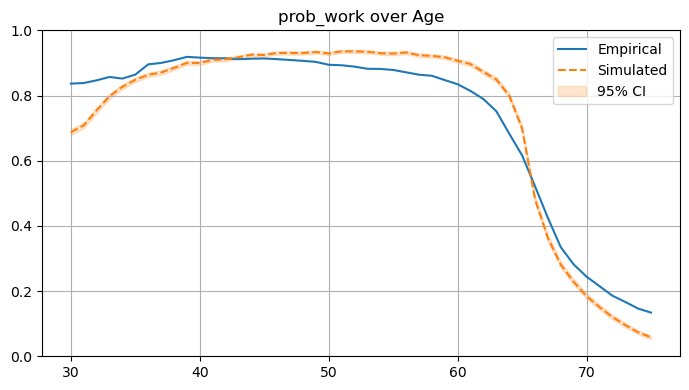

Saved /Users/frederiklarsen/Library/Mobile Documents/com~apple~CloudDocs/KU/Speciale/Figurer/edu1/hours_0_over_age_edu1.png


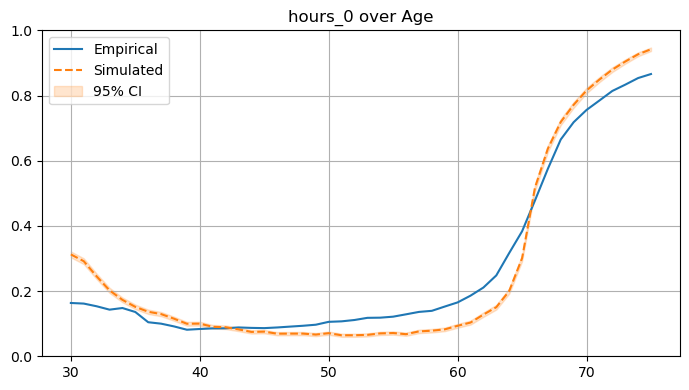

Saved /Users/frederiklarsen/Library/Mobile Documents/com~apple~CloudDocs/KU/Speciale/Figurer/edu1/hours_1_over_age_edu1.png


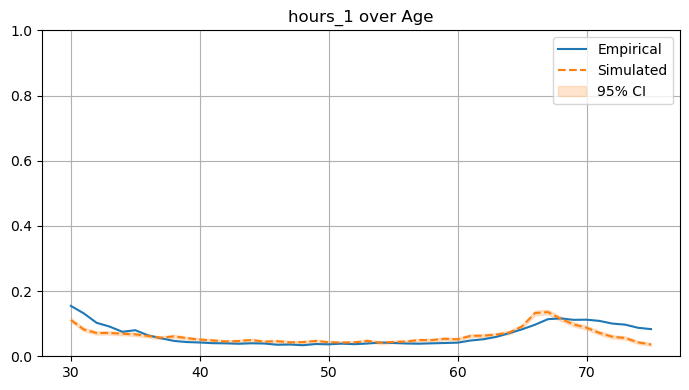

Saved /Users/frederiklarsen/Library/Mobile Documents/com~apple~CloudDocs/KU/Speciale/Figurer/edu1/hours_2_over_age_edu1.png


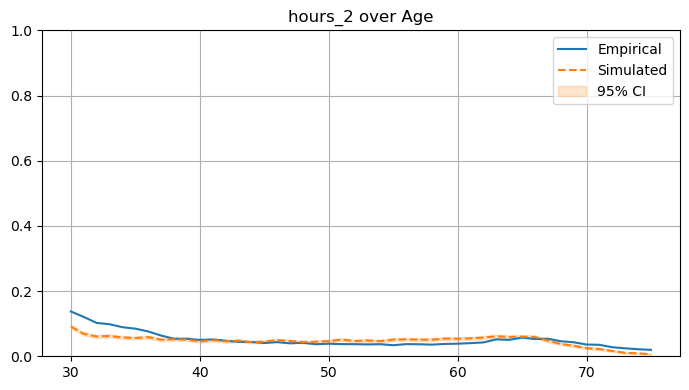

Saved /Users/frederiklarsen/Library/Mobile Documents/com~apple~CloudDocs/KU/Speciale/Figurer/edu1/hours_3_over_age_edu1.png


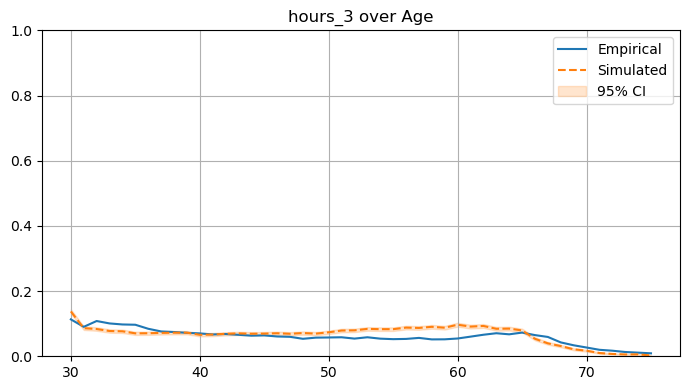

Saved /Users/frederiklarsen/Library/Mobile Documents/com~apple~CloudDocs/KU/Speciale/Figurer/edu1/hours_4_over_age_edu1.png


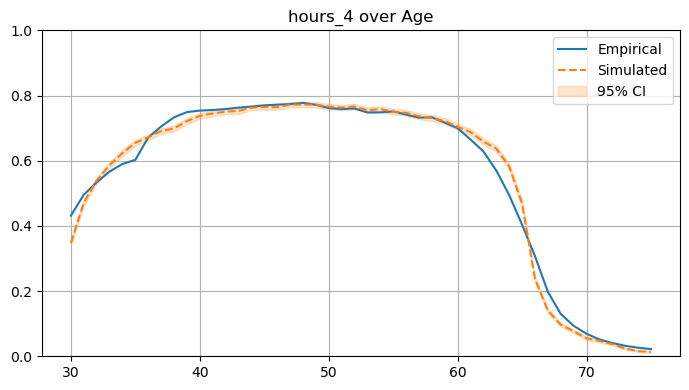

Saved /Users/frederiklarsen/Library/Mobile Documents/com~apple~CloudDocs/KU/Speciale/Figurer/edu1/avg_wealth_over_age_edu1.png


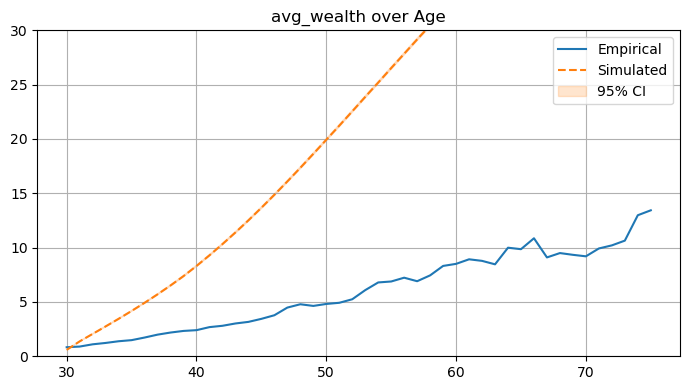

Saved /Users/frederiklarsen/Library/Mobile Documents/com~apple~CloudDocs/KU/Speciale/Figurer/edu1/work_work_over_age_edu1.png


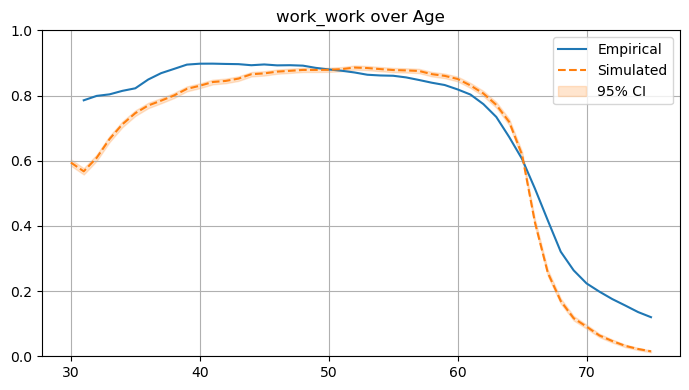

Saved /Users/frederiklarsen/Library/Mobile Documents/com~apple~CloudDocs/KU/Speciale/Figurer/edu1/nowork_nowork_over_age_edu1.png


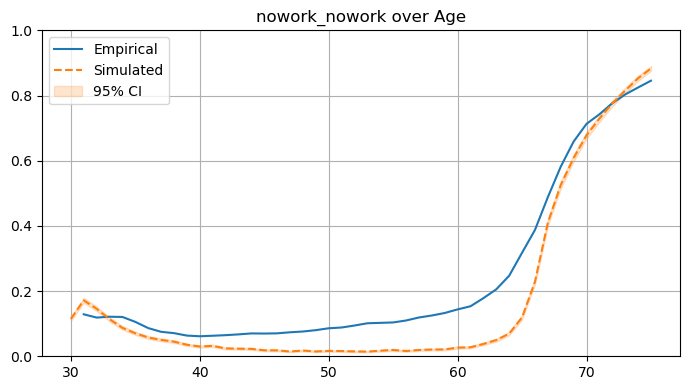

Saved /Users/frederiklarsen/Library/Mobile Documents/com~apple~CloudDocs/KU/Speciale/Figurer/edu1/avg_experience_over_age_edu1.png


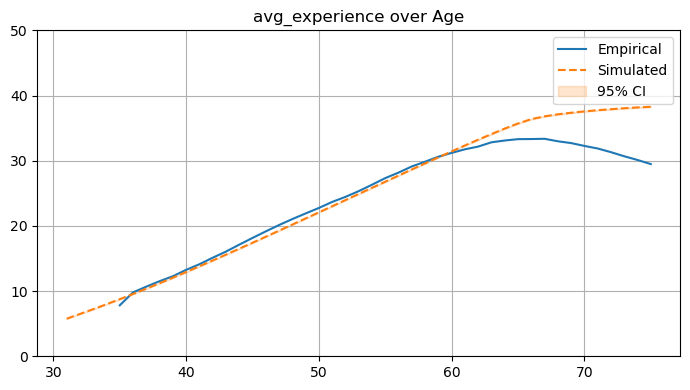

Saved /Users/frederiklarsen/Library/Mobile Documents/com~apple~CloudDocs/KU/Speciale/Figurer/edu1/avg_labor_income_over_age_edu1.png


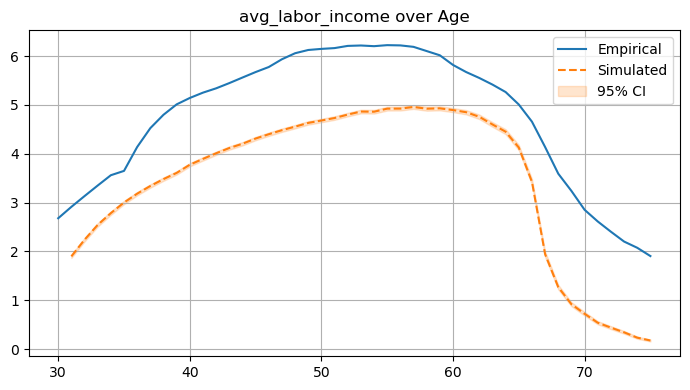

Saved /Users/frederiklarsen/Library/Mobile Documents/com~apple~CloudDocs/KU/Speciale/Figurer/edu1/avg_wage_over_age_edu1.png


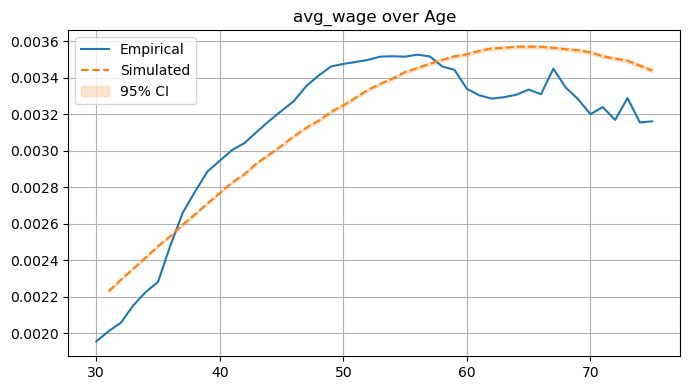

Saved /Users/frederiklarsen/Library/Mobile Documents/com~apple~CloudDocs/KU/Speciale/Figurer/edu1/avg_hours_over_age_edu1.png


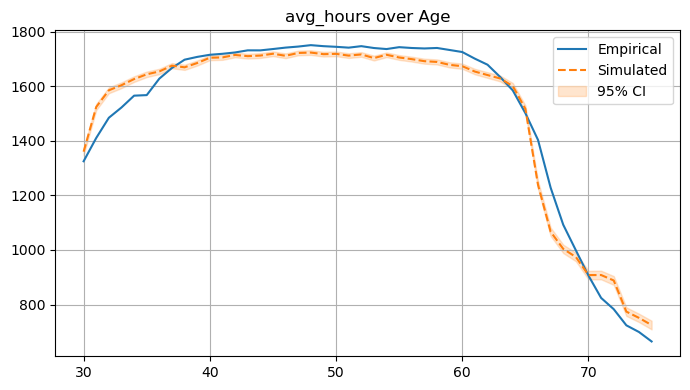

In [13]:
edu = df_edu_2.copy().loc[df_edu_2.age <= 75]       # empirical
moments_sim = compute_simulation_moments_with_ci(df_sim, start_age, hours_map)  # Call the function
moments_sim = moments_sim.loc[moments_sim.age <= 75]  # Filter simulated + CIs

# location to store plots in
BASE = "/Users/frederiklarsen/Library/Mobile Documents/com~apple~CloudDocs/KU/Speciale/Figurer"
# print plots
plot_empirical_vs_simulated_with_ci(edu, moments_sim, BASE, out_subfolder="edu1")
